# LSTM - vanilla

In [1]:
best_model = "best_model23.pt"

## Load and prepare data

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/salmawafa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


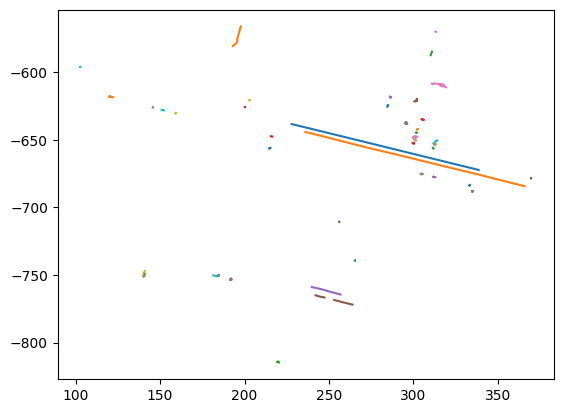

In [4]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [5]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, 2:4].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0), # (1,2)
            scale=torch.tensor(self.scale, dtype=torch.float32), # scalar e.g. 7.0
        )
        
        # print(f'x: {data_item.x.shape}')
        # print(f'y: {data_item.y.shape}')

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [6]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [13]:
# class AutoRegressiveLSTM(nn.Module):
#     def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
#         super().__init__()
#         self.hidden_dim = hidden_dim
#         self.num_layers = num_layers
#         self.future_steps = future_steps

#         # Encoder: takes in past trajectory
#         self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

#         # Decoder: predicts future positions one step at a time
#         self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
#         self.out = nn.Linear(hidden_dim, output_dim)

#     def forward(self, data, forcing_ratio = 0.5):
#     # def forward(self, data):
#         x = data.x[..., :5]  # Use position + velocity
#         x = x.reshape(-1, 50, 50, 5)[:, 0, :, :]  # (batch, 50, 5), ego only
         
#         batch_size = x.size(0)
        
#         if self.training:
#             future = data.y.view(batch_size, 60, 2) # (batch, 60, 2)

#         # Encode past
#         _, (hidden, cell) = self.encoder(x)

#         # Initialize decoder input with last observed position
#         decoder_input = x[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)
        
#         # print("decoder_input.shape - initial", decoder_input.shape)  # should be (batch, 1, 2)

#         outputs = []

#         for t in range(self.future_steps):
#             output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
#             pred = self.out(output)  # (batch, 1, 2)
#             outputs.append(pred)

#             # TODO: remove forcing ratio?
#             if self.training and random.random() < forcing_ratio:
#             # if self.training:
#                 decoder_input = future[:, t].unsqueeze(1)  # ground truth
#                 # print("decoder_input.shape - teacher forcing", decoder_input.shape)  # should be (batch, 1, 2)
#             else:
#                 decoder_input = pred.detach()  # predicted output as next input
#                 # print("decoder_input.shape - autoreg", decoder_input.shape)  # should be (batch, 1, 2)

#         outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
#         return outputs

In [8]:
class AutoRegressiveLSTM(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=512, output_dim=2, num_layers=1, future_steps=60):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.future_steps = future_steps

        # Separate encoder for ego and each neighbor agent
        self.encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.neighbor_encoder = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # self.neighbor_encoder2 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        # self.neighbor_encoder3 = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Decoder
        self.decoder = nn.LSTM(input_size=2, hidden_size=hidden_dim * 4, num_layers=num_layers, batch_first=True)
        self.out = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, data, forcing_ratio=0.5):
        x = data.x[..., :5]  # Only pos & vel
        x = x.reshape(-1, 50, 50, 5)  # (batch, agents=50, time=50, features=5)
        batch_size = x.size(0)
        device = x.device

        if self.training:
            future = data.y.view(batch_size, 60, 2)

        # ---- EGO TRAJECTORY ----
        ego_traj = x[:, 0, :, :]  # (batch, 50, 5)

        # ---- DISTANCES TO OTHER AGENTS ----
        ego_pos = x[:, 0, 49, :2].unsqueeze(1)  # (batch, 1, 2)
        agent_pos = x[:, :, 49, :2]  # (batch, 50, 2)
        dists = torch.norm(agent_pos - ego_pos, dim=-1)  # (batch, 50)
        dists[:, 0] = float('inf')  # mask out ego

        # ---- SELECT 3 CLOSEST NEIGHBORS ----
        _, neighbor_ids = torch.topk(dists, k=3, dim=1, largest=False)  # (batch, 3)

        # ---- ENCODE EGO ----
        _, (ego_hidden, ego_cell) = self.encoder(ego_traj)  # each: (num_layers, batch, hidden_dim)

        # ---- ENCODE NEIGHBORS ----
        neighbor_hidden_list = []
        neighbor_cell_list = []

        for i in range(3):
            idx = neighbor_ids[:, i]  # (batch,)
            neighbor_trajs = torch.stack([x[b, idx[b]] for b in range(batch_size)], dim=0)  # (batch, 50, 5)

            _, (n_hidden, n_cell) = self.neighbor_encoder(neighbor_trajs)  # both: (num_layers, batch, hidden_dim)

            neighbor_hidden_list.append(n_hidden)
            neighbor_cell_list.append(n_cell)

        # ---- CONCATENATE HIDDEN AND CELL STATES ----
        hidden = torch.cat([ego_hidden] + neighbor_hidden_list, dim=2)  # (num_layers, batch, hidden_dim * 4)
        cell   = torch.cat([ego_cell]   + neighbor_cell_list, dim=2)   # (num_layers, batch, hidden_dim * 4)

        # ---- DECODER INIT ----
        decoder_input = ego_traj[:, -1, :2].unsqueeze(1)  # (batch, 1, 2)

        outputs = []

        for t in range(self.future_steps):
            output, (hidden, cell) = self.decoder(decoder_input, (hidden, cell))
            pred = self.out(output)  # (batch, 1, 2)
            outputs.append(pred)

            if self.training and random.random() < forcing_ratio:
                decoder_input = future[:, t].unsqueeze(1)
            else:
                decoder_input = pred.detach()

        outputs = torch.cat(outputs, dim=1)  # (batch, 60, 2)
        return outputs

# Train

In [9]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        forcing_ratio = max(0.0, 1.0 - epoch / 50)
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch, forcing_ratio=forcing_ratio)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                # batch.scale turns scale from 7.0 or (1,) shape i.e. scalar to (B,) shape
                # batch.origin turns origin from (1,2) shape to (B,2)
                
                # then .view(-1, 1, 1) turns scale from (B,) to (B, 1, 1)
                # then .unsqueeze(1) turns origin from (B, 2) to (B, 1, 2)
                # because pred and y have shapes (B, 60, 2) so these transformations make them compatible for the calculation
                
                # TODO: should scale?
                pred_unnorm = pred * batch.scale.view(-1, 1, 1)
                y_unnorm = y * batch.scale.view(-1, 1, 1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE (normalized) {val_loss:.4f} | "
            f"Val MAE (true) {val_mae:.4f} | Val MSE (true) {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), best_model)
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load(best_model))
    return model

In [14]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = AutoRegressiveLSTM()
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        # lr = 0.007,  # => 8.98, ps: 10.01
        lr=0.005,  # Lower learning rate
        patience=20,  # More patience
        epochs=150
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1)
            y = y * batch.scale.view(-1, 1, 1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

In [15]:
train_and_evaluate_model()

Epoch:   0%|          | 0/150 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_73518/1407810273.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   0%|          | 0/150 [03:42<?, ?epoch/s]

Epoch 000 | LR 0.004750 | Train MSE 0.7295 | Val MSE (normalized) 0.8587 | Val MAE (true) 5.0835 | Val MSE (true) 42.0778
Sample pred first 3 steps: [[ 0.00987009 -0.04177123]
 [ 0.18641004 -0.1074775 ]
 [ 0.31373867 -0.25461796]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: inf -> 0.858730


Epoch:   1%|          | 1/150 [07:20<9:12:33, 222.51s/epoch]

Epoch 001 | LR 0.004513 | Train MSE 0.0091 | Val MSE (normalized) 0.4909 | Val MAE (true) 3.7099 | Val MSE (true) 24.0521
Validation improved: 0.858730 -> 0.490860


Epoch:   2%|▏         | 3/150 [10:59<8:56:56, 219.16s/epoch]

Epoch 002 | LR 0.004287 | Train MSE 0.0049 | Val MSE (normalized) 0.5200 | Val MAE (true) 3.8779 | Val MSE (true) 25.4798


Epoch:   3%|▎         | 4/150 [14:52<9:07:16, 224.91s/epoch]

Epoch 003 | LR 0.004073 | Train MSE 0.0033 | Val MSE (normalized) 0.9031 | Val MAE (true) 4.8668 | Val MSE (true) 44.2521


Epoch:   3%|▎         | 4/150 [18:31<9:07:16, 224.91s/epoch]

Epoch 004 | LR 0.003869 | Train MSE 0.0024 | Val MSE (normalized) 0.4248 | Val MAE (true) 3.4152 | Val MSE (true) 20.8159
Validation improved: 0.490860 -> 0.424813


Epoch:   3%|▎         | 5/150 [22:20<8:58:36, 222.87s/epoch]

Epoch 005 | LR 0.003675 | Train MSE 0.0022 | Val MSE (normalized) 0.1961 | Val MAE (true) 2.2055 | Val MSE (true) 9.6083
Sample pred first 3 steps: [[ 1.4906608e-02  7.4067526e-04]
 [ 4.9430877e-05  2.1071546e-04]
 [-1.9103251e-03 -1.0451371e-02]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   4%|▍         | 6/150 [22:20<8:59:18, 224.71s/epoch]

Validation improved: 0.424813 -> 0.196088


Epoch:   5%|▍         | 7/150 [26:03<8:54:33, 224.29s/epoch]

Epoch 006 | LR 0.003492 | Train MSE 0.0022 | Val MSE (normalized) 0.4092 | Val MAE (true) 3.0331 | Val MSE (true) 20.0485


Epoch:   5%|▍         | 7/150 [31:10<8:54:33, 224.29s/epoch]

Epoch 007 | LR 0.003317 | Train MSE 0.0022 | Val MSE (normalized) 0.1544 | Val MAE (true) 1.9933 | Val MSE (true) 7.5680
Validation improved: 0.196088 -> 0.154449


Epoch:   6%|▌         | 9/150 [37:08<11:07:15, 283.94s/epoch]

Epoch 008 | LR 0.003151 | Train MSE 0.0021 | Val MSE (normalized) 0.1922 | Val MAE (true) 2.0454 | Val MSE (true) 9.4184


Epoch:   7%|▋         | 10/150 [42:51<11:45:01, 302.15s/epoch]

Epoch 009 | LR 0.002994 | Train MSE 0.0021 | Val MSE (normalized) 2.1150 | Val MAE (true) 7.1007 | Val MSE (true) 103.6342


Epoch:   7%|▋         | 11/150 [48:21<11:59:54, 310.75s/epoch]

Epoch 010 | LR 0.002844 | Train MSE 0.0022 | Val MSE (normalized) 1.3108 | Val MAE (true) 6.2967 | Val MSE (true) 64.2315
Sample pred first 3 steps: [[ 0.05852517  0.00929828]
 [ 0.05314463 -0.00026329]
 [ 0.03650323 -0.01693049]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:   8%|▊         | 12/150 [53:28<11:51:56, 309.54s/epoch]

Epoch 011 | LR 0.002702 | Train MSE 0.0022 | Val MSE (normalized) 0.2576 | Val MAE (true) 2.5280 | Val MSE (true) 12.6228


Epoch:   9%|▊         | 13/150 [58:29<11:40:49, 306.93s/epoch]

Epoch 012 | LR 0.002567 | Train MSE 0.0021 | Val MSE (normalized) 0.4212 | Val MAE (true) 3.1005 | Val MSE (true) 20.6390


Epoch:   9%|▉         | 14/150 [1:03:28<11:30:57, 304.84s/epoch]

Epoch 013 | LR 0.002438 | Train MSE 0.0021 | Val MSE (normalized) 0.2362 | Val MAE (true) 2.5314 | Val MSE (true) 11.5747


Epoch:  10%|█         | 15/150 [1:08:36<11:27:51, 305.72s/epoch]

Epoch 014 | LR 0.002316 | Train MSE 0.0024 | Val MSE (normalized) 0.5772 | Val MAE (true) 3.8398 | Val MSE (true) 28.2804


Epoch:  11%|█         | 16/150 [1:13:54<11:31:03, 309.43s/epoch]

Epoch 015 | LR 0.002201 | Train MSE 0.0025 | Val MSE (normalized) 0.9738 | Val MAE (true) 4.9342 | Val MSE (true) 47.7143
Sample pred first 3 steps: [[-0.04115406  0.00529772]
 [ 0.03371676 -0.00849929]
 [ 0.07462494 -0.00314074]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  11%|█▏        | 17/150 [1:18:56<11:21:03, 307.25s/epoch]

Epoch 016 | LR 0.002091 | Train MSE 0.0027 | Val MSE (normalized) 0.2121 | Val MAE (true) 2.1120 | Val MSE (true) 10.3951


Epoch:  12%|█▏        | 18/150 [1:24:05<11:16:53, 307.68s/epoch]

Epoch 017 | LR 0.001986 | Train MSE 0.0024 | Val MSE (normalized) 0.3451 | Val MAE (true) 2.6817 | Val MSE (true) 16.9112


Epoch:  13%|█▎        | 19/150 [1:29:19<11:15:56, 309.59s/epoch]

Epoch 018 | LR 0.001887 | Train MSE 0.0023 | Val MSE (normalized) 0.2474 | Val MAE (true) 2.3819 | Val MSE (true) 12.1213


Epoch:  13%|█▎        | 19/150 [1:34:32<11:15:56, 309.59s/epoch]

Epoch 019 | LR 0.001792 | Train MSE 0.0022 | Val MSE (normalized) 0.1540 | Val MAE (true) 1.8497 | Val MSE (true) 7.5483
Validation improved: 0.154449 -> 0.154047


Epoch:  14%|█▍        | 21/150 [1:39:34<11:02:12, 308.00s/epoch]

Epoch 020 | LR 0.001703 | Train MSE 0.0021 | Val MSE (normalized) 0.3354 | Val MAE (true) 2.7479 | Val MSE (true) 16.4339
Sample pred first 3 steps: [[ 0.00562604  0.00396239]
 [ 0.02104244 -0.00282476]
 [ 0.02329289 -0.0029112 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  15%|█▍        | 22/150 [1:44:41<10:56:11, 307.59s/epoch]

Epoch 021 | LR 0.001618 | Train MSE 0.0023 | Val MSE (normalized) 0.1640 | Val MAE (true) 1.9187 | Val MSE (true) 8.0355


Epoch:  15%|█▌        | 23/150 [1:49:36<10:43:29, 304.01s/epoch]

Epoch 022 | LR 0.001537 | Train MSE 0.0020 | Val MSE (normalized) 0.2044 | Val MAE (true) 2.0458 | Val MSE (true) 10.0162


Epoch:  15%|█▌        | 23/150 [1:54:43<10:43:29, 304.01s/epoch]

Epoch 023 | LR 0.001460 | Train MSE 0.0020 | Val MSE (normalized) 0.1502 | Val MAE (true) 1.7918 | Val MSE (true) 7.3619
Validation improved: 0.154047 -> 0.150244


Epoch:  17%|█▋        | 25/150 [2:00:01<10:43:02, 308.66s/epoch]

Epoch 024 | LR 0.001387 | Train MSE 0.0024 | Val MSE (normalized) 0.0864 | Val MAE (true) 1.3223 | Val MSE (true) 4.2327
Validation improved: 0.150244 -> 0.086381


Epoch:  17%|█▋        | 26/150 [2:05:10<10:37:51, 308.64s/epoch]

Epoch 025 | LR 0.001318 | Train MSE 0.0020 | Val MSE (normalized) 0.2173 | Val MAE (true) 2.3935 | Val MSE (true) 10.6482
Sample pred first 3 steps: [[-0.02052433  0.01321198]
 [-0.03653935  0.00019725]
 [-0.05708021  0.00634203]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  18%|█▊        | 27/150 [2:10:25<10:36:42, 310.59s/epoch]

Epoch 026 | LR 0.001252 | Train MSE 0.0022 | Val MSE (normalized) 0.1590 | Val MAE (true) 1.9725 | Val MSE (true) 7.7934


Epoch:  19%|█▊        | 28/150 [2:15:37<10:32:53, 311.26s/epoch]

Epoch 027 | LR 0.001189 | Train MSE 0.0022 | Val MSE (normalized) 0.1257 | Val MAE (true) 1.6616 | Val MSE (true) 6.1572


Epoch:  19%|█▉        | 29/150 [2:20:49<10:27:47, 311.30s/epoch]

Epoch 028 | LR 0.001130 | Train MSE 0.0022 | Val MSE (normalized) 0.1156 | Val MAE (true) 1.5848 | Val MSE (true) 5.6639


Epoch:  20%|██        | 30/150 [2:25:57<10:20:32, 310.27s/epoch]

Epoch 029 | LR 0.001073 | Train MSE 0.0021 | Val MSE (normalized) 0.2903 | Val MAE (true) 2.4220 | Val MSE (true) 14.2236


Epoch:  21%|██        | 31/150 [2:30:55<10:08:24, 306.76s/epoch]

Epoch 030 | LR 0.001020 | Train MSE 0.0027 | Val MSE (normalized) 0.1139 | Val MAE (true) 1.6011 | Val MSE (true) 5.5797
Sample pred first 3 steps: [[ 0.00703037 -0.01488402]
 [-0.00034807 -0.02392662]
 [-0.00261255 -0.03514748]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  21%|██▏       | 32/150 [2:36:03<10:03:46, 307.00s/epoch]

Epoch 031 | LR 0.000969 | Train MSE 0.0027 | Val MSE (normalized) 0.2558 | Val MAE (true) 2.4008 | Val MSE (true) 12.5344


Epoch:  21%|██▏       | 32/150 [2:41:05<10:03:46, 307.00s/epoch]

Epoch 032 | LR 0.000920 | Train MSE 0.0023 | Val MSE (normalized) 0.0670 | Val MAE (true) 1.0539 | Val MSE (true) 3.2809
Validation improved: 0.086381 -> 0.066958


Epoch:  23%|██▎       | 34/150 [2:46:09<9:49:51, 305.10s/epoch] 

Epoch 033 | LR 0.000874 | Train MSE 0.0027 | Val MSE (normalized) 0.1827 | Val MAE (true) 2.1480 | Val MSE (true) 8.9508


Epoch:  23%|██▎       | 35/150 [2:51:12<9:43:15, 304.31s/epoch]

Epoch 034 | LR 0.000830 | Train MSE 0.0030 | Val MSE (normalized) 0.1769 | Val MAE (true) 1.9523 | Val MSE (true) 8.6695


Epoch:  24%|██▍       | 36/150 [2:56:10<9:34:58, 302.62s/epoch]

Epoch 035 | LR 0.000789 | Train MSE 0.0029 | Val MSE (normalized) 0.2317 | Val MAE (true) 2.5170 | Val MSE (true) 11.3544
Sample pred first 3 steps: [[-0.0004756   0.03083771]
 [ 0.00487562  0.04126015]
 [ 0.00503826  0.04999924]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  25%|██▍       | 37/150 [3:01:13<9:29:44, 302.52s/epoch]

Epoch 036 | LR 0.000749 | Train MSE 0.0027 | Val MSE (normalized) 0.0724 | Val MAE (true) 1.1934 | Val MSE (true) 3.5477


Epoch:  25%|██▌       | 38/150 [3:06:31<9:33:49, 307.41s/epoch]

Epoch 037 | LR 0.000712 | Train MSE 0.0036 | Val MSE (normalized) 0.1003 | Val MAE (true) 1.5322 | Val MSE (true) 4.9135


Epoch:  26%|██▌       | 39/150 [3:11:29<9:23:14, 304.46s/epoch]

Epoch 038 | LR 0.000676 | Train MSE 0.0034 | Val MSE (normalized) 0.0777 | Val MAE (true) 1.2678 | Val MSE (true) 3.8070


Epoch:  27%|██▋       | 40/150 [3:16:35<9:18:52, 304.84s/epoch]

Epoch 039 | LR 0.000643 | Train MSE 0.0039 | Val MSE (normalized) 0.1385 | Val MAE (true) 1.7569 | Val MSE (true) 6.7852


Epoch:  27%|██▋       | 41/150 [3:21:38<9:12:42, 304.25s/epoch]

Epoch 040 | LR 0.000610 | Train MSE 0.0071 | Val MSE (normalized) 0.0756 | Val MAE (true) 1.2281 | Val MSE (true) 3.7058
Sample pred first 3 steps: [[-0.00807488  0.00171521]
 [-0.00169864  0.01026624]
 [-0.00158173  0.00799001]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  27%|██▋       | 41/150 [3:27:00<9:12:42, 304.25s/epoch]

Epoch 041 | LR 0.000580 | Train MSE 0.0075 | Val MSE (normalized) 0.0647 | Val MAE (true) 1.1426 | Val MSE (true) 3.1721
Validation improved: 0.066958 -> 0.064737


Epoch:  28%|██▊       | 42/150 [3:32:04<9:17:35, 309.77s/epoch]

Epoch 042 | LR 0.000551 | Train MSE 0.0049 | Val MSE (normalized) 0.0614 | Val MAE (true) 1.0846 | Val MSE (true) 3.0064
Validation improved: 0.064737 -> 0.061354


Epoch:  29%|██▊       | 43/150 [3:37:08<9:09:44, 308.27s/epoch]

Epoch 043 | LR 0.000523 | Train MSE 0.0054 | Val MSE (normalized) 0.0613 | Val MAE (true) 1.0906 | Val MSE (true) 3.0052
Validation improved: 0.061354 -> 0.061330


Epoch:  30%|███       | 45/150 [3:42:17<8:57:50, 307.34s/epoch]

Epoch 044 | LR 0.000497 | Train MSE 0.0093 | Val MSE (normalized) 0.0655 | Val MAE (true) 1.1096 | Val MSE (true) 3.2088


Epoch:  31%|███       | 46/150 [3:47:34<8:57:49, 310.28s/epoch]

Epoch 045 | LR 0.000472 | Train MSE 0.0135 | Val MSE (normalized) 0.0619 | Val MAE (true) 1.0678 | Val MSE (true) 3.0333
Sample pred first 3 steps: [[-0.00151179 -0.00214816]
 [ 0.0027081  -0.00470585]
 [ 0.00756967  0.0014534 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  31%|███▏      | 47/150 [3:53:01<9:01:24, 315.38s/epoch]

Epoch 046 | LR 0.000449 | Train MSE 0.0195 | Val MSE (normalized) 0.1808 | Val MAE (true) 2.2774 | Val MSE (true) 8.8585


Epoch:  31%|███▏      | 47/150 [3:58:14<9:01:24, 315.38s/epoch]

Epoch 047 | LR 0.000426 | Train MSE 0.0233 | Val MSE (normalized) 0.0589 | Val MAE (true) 1.0110 | Val MSE (true) 2.8867
Validation improved: 0.061330 -> 0.058913


Epoch:  33%|███▎      | 49/150 [4:03:22<8:46:20, 312.68s/epoch]

Epoch 048 | LR 0.000405 | Train MSE 0.0329 | Val MSE (normalized) 0.0593 | Val MAE (true) 1.0739 | Val MSE (true) 2.9072


Epoch:  33%|███▎      | 50/150 [4:08:34<8:40:32, 312.32s/epoch]

Epoch 049 | LR 0.000385 | Train MSE 0.0408 | Val MSE (normalized) 0.0591 | Val MAE (true) 1.0727 | Val MSE (true) 2.8955


Epoch:  33%|███▎      | 50/150 [4:13:41<8:40:32, 312.32s/epoch]

Epoch 050 | LR 0.000365 | Train MSE 0.0598 | Val MSE (normalized) 0.0570 | Val MAE (true) 1.0460 | Val MSE (true) 2.7936
Sample pred first 3 steps: [[0.02666005 0.0339631 ]
 [0.02032633 0.02605398]
 [0.01321274 0.03438574]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.058913 -> 0.057012


Epoch:  34%|███▍      | 51/150 [4:18:57<8:33:01, 310.93s/epoch]

Epoch 051 | LR 0.000347 | Train MSE 0.0533 | Val MSE (normalized) 0.0548 | Val MAE (true) 1.0369 | Val MSE (true) 2.6875
Validation improved: 0.057012 -> 0.054846


Epoch:  35%|███▍      | 52/150 [4:24:16<8:30:25, 312.50s/epoch]

Epoch 052 | LR 0.000330 | Train MSE 0.0509 | Val MSE (normalized) 0.0449 | Val MAE (true) 0.8326 | Val MSE (true) 2.2001
Validation improved: 0.054846 -> 0.044900


Epoch:  36%|███▌      | 54/150 [4:29:39<8:26:41, 316.68s/epoch]

Epoch 053 | LR 0.000313 | Train MSE 0.0502 | Val MSE (normalized) 0.0456 | Val MAE (true) 0.8662 | Val MSE (true) 2.2344


Epoch:  37%|███▋      | 55/150 [4:34:58<8:22:38, 317.46s/epoch]

Epoch 054 | LR 0.000298 | Train MSE 0.0480 | Val MSE (normalized) 0.0454 | Val MAE (true) 0.8883 | Val MSE (true) 2.2262


Epoch:  37%|███▋      | 55/150 [4:40:18<8:22:38, 317.46s/epoch]

Epoch 055 | LR 0.000283 | Train MSE 0.0478 | Val MSE (normalized) 0.0469 | Val MAE (true) 0.9453 | Val MSE (true) 2.2983
Sample pred first 3 steps: [[ 0.00401236  0.00434035]
 [ 0.01174408 -0.00426475]
 [ 0.01824128 -0.0008882 ]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  37%|███▋      | 56/150 [4:45:28<8:18:49, 318.40s/epoch]

Epoch 056 | LR 0.000269 | Train MSE 0.0473 | Val MSE (normalized) 0.0446 | Val MAE (true) 0.8593 | Val MSE (true) 2.1872
Validation improved: 0.044900 -> 0.044636


Epoch:  38%|███▊      | 57/150 [4:50:54<8:09:48, 316.01s/epoch]

Epoch 057 | LR 0.000255 | Train MSE 0.0466 | Val MSE (normalized) 0.0439 | Val MAE (true) 0.8629 | Val MSE (true) 2.1490
Validation improved: 0.044636 -> 0.043857


Epoch:  39%|███▊      | 58/150 [4:56:13<8:09:19, 319.13s/epoch]

Epoch 058 | LR 0.000242 | Train MSE 0.0464 | Val MSE (normalized) 0.0420 | Val MAE (true) 0.8160 | Val MSE (true) 2.0568
Validation improved: 0.043857 -> 0.041976


Epoch:  40%|████      | 60/150 [5:01:29<7:56:41, 317.79s/epoch]

Epoch 059 | LR 0.000230 | Train MSE 0.0461 | Val MSE (normalized) 0.0429 | Val MAE (true) 0.8375 | Val MSE (true) 2.1025


Epoch:  41%|████      | 61/150 [5:06:43<7:49:58, 316.84s/epoch]

Epoch 060 | LR 0.000219 | Train MSE 0.0459 | Val MSE (normalized) 0.0429 | Val MAE (true) 0.8421 | Val MSE (true) 2.1022
Sample pred first 3 steps: [[-0.00259482  0.00017009]
 [-0.01837625  0.00973592]
 [-0.02138334  0.01570868]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  41%|████      | 61/150 [5:12:03<7:49:58, 316.84s/epoch]

Epoch 061 | LR 0.000208 | Train MSE 0.0451 | Val MSE (normalized) 0.0408 | Val MAE (true) 0.7933 | Val MSE (true) 2.0008
Validation improved: 0.041976 -> 0.040833


Epoch:  42%|████▏     | 63/150 [5:17:20<7:40:25, 317.53s/epoch]

Epoch 062 | LR 0.000197 | Train MSE 0.0450 | Val MSE (normalized) 0.0440 | Val MAE (true) 0.8982 | Val MSE (true) 2.1545


Epoch:  43%|████▎     | 64/150 [5:22:25<7:29:47, 313.81s/epoch]

Epoch 063 | LR 0.000188 | Train MSE 0.0444 | Val MSE (normalized) 0.0409 | Val MAE (true) 0.7972 | Val MSE (true) 2.0027


Epoch:  43%|████▎     | 65/150 [5:27:47<7:27:45, 316.07s/epoch]

Epoch 064 | LR 0.000178 | Train MSE 0.0442 | Val MSE (normalized) 0.0453 | Val MAE (true) 0.9639 | Val MSE (true) 2.2212


Epoch:  43%|████▎     | 65/150 [5:33:05<7:27:45, 316.07s/epoch]

Epoch 065 | LR 0.000169 | Train MSE 0.0441 | Val MSE (normalized) 0.0405 | Val MAE (true) 0.7896 | Val MSE (true) 1.9867
Sample pred first 3 steps: [[ 3.0290335e-05 -2.9947162e-03]
 [-6.6298731e-03  3.8307011e-03]
 [-9.4972588e-03  6.9917068e-03]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.040833 -> 0.040544


Epoch:  45%|████▍     | 67/150 [5:38:10<7:13:08, 313.12s/epoch]

Epoch 066 | LR 0.000161 | Train MSE 0.0437 | Val MSE (normalized) 0.0424 | Val MAE (true) 0.8748 | Val MSE (true) 2.0799


Epoch:  45%|████▍     | 67/150 [5:43:25<7:13:08, 313.12s/epoch]

Epoch 067 | LR 0.000153 | Train MSE 0.0435 | Val MSE (normalized) 0.0399 | Val MAE (true) 0.7854 | Val MSE (true) 1.9529
Validation improved: 0.040544 -> 0.039854


Epoch:  46%|████▌     | 69/150 [5:48:25<6:57:47, 309.47s/epoch]

Epoch 068 | LR 0.000145 | Train MSE 0.0428 | Val MSE (normalized) 0.0417 | Val MAE (true) 0.8605 | Val MSE (true) 2.0422


Epoch:  47%|████▋     | 70/150 [5:53:24<6:48:48, 306.61s/epoch]

Epoch 069 | LR 0.000138 | Train MSE 0.0430 | Val MSE (normalized) 0.0412 | Val MAE (true) 0.8287 | Val MSE (true) 2.0200


Epoch:  47%|████▋     | 70/150 [5:58:39<6:48:48, 306.61s/epoch]

Epoch 070 | LR 0.000131 | Train MSE 0.0430 | Val MSE (normalized) 0.0395 | Val MAE (true) 0.7886 | Val MSE (true) 1.9367
Sample pred first 3 steps: [[-0.01687998 -0.00211784]
 [-0.01967231 -0.00279121]
 [-0.02092515 -0.00563417]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.039854 -> 0.039524


Epoch:  48%|████▊     | 72/150 [6:03:51<6:42:41, 309.77s/epoch]

Epoch 071 | LR 0.000124 | Train MSE 0.0421 | Val MSE (normalized) 0.0402 | Val MAE (true) 0.8122 | Val MSE (true) 1.9715


Epoch:  48%|████▊     | 72/150 [6:09:02<6:42:41, 309.77s/epoch]

Epoch 072 | LR 0.000118 | Train MSE 0.0424 | Val MSE (normalized) 0.0393 | Val MAE (true) 0.7860 | Val MSE (true) 1.9254
Validation improved: 0.039524 -> 0.039295


Epoch:  49%|████▉     | 74/150 [6:14:11<6:32:38, 309.98s/epoch]

Epoch 073 | LR 0.000112 | Train MSE 0.0418 | Val MSE (normalized) 0.0403 | Val MAE (true) 0.8259 | Val MSE (true) 1.9767


Epoch:  50%|█████     | 75/150 [6:19:27<6:29:39, 311.73s/epoch]

Epoch 074 | LR 0.000107 | Train MSE 0.0420 | Val MSE (normalized) 0.0396 | Val MAE (true) 0.7844 | Val MSE (true) 1.9390


Epoch:  50%|█████     | 75/150 [6:24:36<6:29:39, 311.73s/epoch]

Epoch 075 | LR 0.000101 | Train MSE 0.0414 | Val MSE (normalized) 0.0392 | Val MAE (true) 0.7825 | Val MSE (true) 1.9189
Sample pred first 3 steps: [[ 0.00759787 -0.00347436]
 [ 0.00911445 -0.00339509]
 [ 0.01419905 -0.00686928]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  51%|█████     | 76/150 [6:24:37<6:23:38, 311.07s/epoch]

Validation improved: 0.039295 -> 0.039160


Epoch:  51%|█████     | 76/150 [6:29:57<6:23:38, 311.07s/epoch]

Epoch 076 | LR 0.000096 | Train MSE 0.0417 | Val MSE (normalized) 0.0391 | Val MAE (true) 0.7807 | Val MSE (true) 1.9178
Validation improved: 0.039160 -> 0.039140


Epoch:  51%|█████▏    | 77/150 [6:35:29<6:21:50, 313.84s/epoch]

Epoch 077 | LR 0.000091 | Train MSE 0.0414 | Val MSE (normalized) 0.0387 | Val MAE (true) 0.7625 | Val MSE (true) 1.8944
Validation improved: 0.039140 -> 0.038660


Epoch:  52%|█████▏    | 78/150 [6:40:43<6:23:23, 319.49s/epoch]

Epoch 078 | LR 0.000087 | Train MSE 0.0410 | Val MSE (normalized) 0.0382 | Val MAE (true) 0.7603 | Val MSE (true) 1.8739
Validation improved: 0.038660 -> 0.038243


Epoch:  53%|█████▎    | 80/150 [6:45:47<6:05:38, 313.41s/epoch]

Epoch 079 | LR 0.000083 | Train MSE 0.0407 | Val MSE (normalized) 0.0412 | Val MAE (true) 0.8692 | Val MSE (true) 2.0195


Epoch:  54%|█████▍    | 81/150 [6:50:53<5:58:09, 311.44s/epoch]

Epoch 080 | LR 0.000078 | Train MSE 0.0406 | Val MSE (normalized) 0.0387 | Val MAE (true) 0.7706 | Val MSE (true) 1.8946
Sample pred first 3 steps: [[ 0.00587257 -0.00393579]
 [ 0.00657519 -0.00317073]
 [ 0.00943172 -0.00822498]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  55%|█████▍    | 82/150 [6:56:06<5:53:17, 311.73s/epoch]

Epoch 081 | LR 0.000075 | Train MSE 0.0405 | Val MSE (normalized) 0.0394 | Val MAE (true) 0.7963 | Val MSE (true) 1.9308


Epoch:  55%|█████▌    | 83/150 [7:01:20<5:48:53, 312.43s/epoch]

Epoch 082 | LR 0.000071 | Train MSE 0.0409 | Val MSE (normalized) 0.0388 | Val MAE (true) 0.7959 | Val MSE (true) 1.9018


Epoch:  56%|█████▌    | 84/150 [7:06:27<5:41:53, 310.81s/epoch]

Epoch 083 | LR 0.000067 | Train MSE 0.0403 | Val MSE (normalized) 0.0385 | Val MAE (true) 0.7849 | Val MSE (true) 1.8876


Epoch:  57%|█████▋    | 85/150 [7:11:34<5:35:36, 309.79s/epoch]

Epoch 084 | LR 0.000064 | Train MSE 0.0406 | Val MSE (normalized) 0.0393 | Val MAE (true) 0.8062 | Val MSE (true) 1.9248


Epoch:  57%|█████▋    | 85/150 [7:16:45<5:35:36, 309.79s/epoch]

Epoch 085 | LR 0.000061 | Train MSE 0.0402 | Val MSE (normalized) 0.0380 | Val MAE (true) 0.7459 | Val MSE (true) 1.8640
Sample pred first 3 steps: [[ 0.00258549 -0.00522108]
 [ 0.00095513 -0.00071746]
 [-0.00239512 -0.00191785]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]
Validation improved: 0.038243 -> 0.038041


Epoch:  57%|█████▋    | 86/150 [7:21:56<5:30:37, 309.97s/epoch]

Epoch 086 | LR 0.000058 | Train MSE 0.0402 | Val MSE (normalized) 0.0379 | Val MAE (true) 0.7506 | Val MSE (true) 1.8587
Validation improved: 0.038041 -> 0.037932


Epoch:  59%|█████▊    | 88/150 [7:27:00<5:18:26, 308.18s/epoch]

Epoch 087 | LR 0.000055 | Train MSE 0.0401 | Val MSE (normalized) 0.0382 | Val MAE (true) 0.7686 | Val MSE (true) 1.8704


Epoch:  59%|█████▉    | 89/150 [7:31:26<5:00:24, 295.48s/epoch]

Epoch 088 | LR 0.000052 | Train MSE 0.0398 | Val MSE (normalized) 0.0396 | Val MAE (true) 0.8083 | Val MSE (true) 1.9413


Epoch:  59%|█████▉    | 89/150 [7:35:01<5:00:24, 295.48s/epoch]

Epoch 089 | LR 0.000049 | Train MSE 0.0398 | Val MSE (normalized) 0.0379 | Val MAE (true) 0.7583 | Val MSE (true) 1.8565
Validation improved: 0.037932 -> 0.037888


Epoch:  61%|██████    | 91/150 [7:38:35<4:09:48, 254.05s/epoch]

Epoch 090 | LR 0.000047 | Train MSE 0.0401 | Val MSE (normalized) 0.0379 | Val MAE (true) 0.7476 | Val MSE (true) 1.8581
Sample pred first 3 steps: [[ 0.00653985 -0.00721311]
 [ 0.00256688 -0.00498901]
 [ 0.00058565 -0.00806772]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  61%|██████▏   | 92/150 [7:42:07<3:53:28, 241.52s/epoch]

Epoch 091 | LR 0.000045 | Train MSE 0.0396 | Val MSE (normalized) 0.0381 | Val MAE (true) 0.7626 | Val MSE (true) 1.8658


Epoch:  62%|██████▏   | 93/150 [7:45:05<3:31:17, 222.41s/epoch]

Epoch 092 | LR 0.000042 | Train MSE 0.0393 | Val MSE (normalized) 0.0381 | Val MAE (true) 0.7566 | Val MSE (true) 1.8676


Epoch:  63%|██████▎   | 94/150 [7:47:28<3:05:22, 198.61s/epoch]

Epoch 093 | LR 0.000040 | Train MSE 0.0393 | Val MSE (normalized) 0.0381 | Val MAE (true) 0.7714 | Val MSE (true) 1.8681


Epoch:  63%|██████▎   | 95/150 [7:49:48<2:46:05, 181.19s/epoch]

Epoch 094 | LR 0.000038 | Train MSE 0.0396 | Val MSE (normalized) 0.0375 | Val MAE (true) 0.7559 | Val MSE (true) 1.8388
Validation improved: 0.037888 -> 0.037526


Epoch:  64%|██████▍   | 96/150 [7:52:08<2:31:49, 168.70s/epoch]

Epoch 095 | LR 0.000036 | Train MSE 0.0394 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7456 | Val MSE (true) 1.8483
Sample pred first 3 steps: [[ 0.00533248 -0.00255211]
 [ 0.0012885  -0.00084481]
 [ 0.00120933 -0.00094729]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  65%|██████▍   | 97/150 [7:54:28<2:21:28, 160.16s/epoch]

Epoch 096 | LR 0.000035 | Train MSE 0.0394 | Val MSE (normalized) 0.0376 | Val MAE (true) 0.7516 | Val MSE (true) 1.8438


Epoch:  65%|██████▌   | 98/150 [7:56:48<2:13:28, 154.01s/epoch]

Epoch 097 | LR 0.000033 | Train MSE 0.0392 | Val MSE (normalized) 0.0381 | Val MAE (true) 0.7654 | Val MSE (true) 1.8645


Epoch:  66%|██████▌   | 99/150 [7:59:10<2:07:56, 150.51s/epoch]

Epoch 098 | LR 0.000031 | Train MSE 0.0393 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7552 | Val MSE (true) 1.8490


Epoch:  66%|██████▌   | 99/150 [8:01:32<2:07:56, 150.51s/epoch]

Epoch 099 | LR 0.000030 | Train MSE 0.0389 | Val MSE (normalized) 0.0375 | Val MAE (true) 0.7464 | Val MSE (true) 1.8357
Validation improved: 0.037526 -> 0.037463


Epoch:  67%|██████▋   | 101/150 [8:03:53<1:58:57, 145.67s/epoch]

Epoch 100 | LR 0.000028 | Train MSE 0.0391 | Val MSE (normalized) 0.0386 | Val MAE (true) 0.7701 | Val MSE (true) 1.8900
Sample pred first 3 steps: [[ 0.00477756 -0.00041136]
 [ 0.00244252  0.0052467 ]
 [ 0.00100155  0.00465205]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  68%|██████▊   | 102/150 [8:06:12<1:54:58, 143.72s/epoch]

Epoch 101 | LR 0.000027 | Train MSE 0.0388 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7511 | Val MSE (true) 1.8457


Epoch:  69%|██████▊   | 103/150 [8:08:31<1:51:30, 142.36s/epoch]

Epoch 102 | LR 0.000025 | Train MSE 0.0391 | Val MSE (normalized) 0.0379 | Val MAE (true) 0.7610 | Val MSE (true) 1.8591


Epoch:  69%|██████▉   | 104/150 [8:10:51<1:48:31, 141.55s/epoch]

Epoch 103 | LR 0.000024 | Train MSE 0.0388 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7491 | Val MSE (true) 1.8329
Validation improved: 0.037463 -> 0.037407


Epoch:  70%|███████   | 105/150 [8:13:11<1:45:57, 141.28s/epoch]

Epoch 104 | LR 0.000023 | Train MSE 0.0387 | Val MSE (normalized) 0.0378 | Val MAE (true) 0.7645 | Val MSE (true) 1.8531


Epoch:  71%|███████   | 106/150 [8:15:32<1:43:34, 141.24s/epoch]

Epoch 105 | LR 0.000022 | Train MSE 0.0388 | Val MSE (normalized) 0.0378 | Val MAE (true) 0.7573 | Val MSE (true) 1.8507
Sample pred first 3 steps: [[ 0.00285751 -0.00200372]
 [ 0.00361399  0.00220217]
 [ 0.00129145 -0.00133369]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  71%|███████▏  | 107/150 [8:17:52<1:40:51, 140.73s/epoch]

Epoch 106 | LR 0.000021 | Train MSE 0.0387 | Val MSE (normalized) 0.0375 | Val MAE (true) 0.7528 | Val MSE (true) 1.8365


Epoch:  71%|███████▏  | 107/150 [8:20:12<1:40:51, 140.73s/epoch]

Epoch 107 | LR 0.000020 | Train MSE 0.0387 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7397 | Val MSE (true) 1.8303
Validation improved: 0.037407 -> 0.037354


Epoch:  73%|███████▎  | 109/150 [8:22:32<1:35:52, 140.31s/epoch]

Epoch 108 | LR 0.000019 | Train MSE 0.0389 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7463 | Val MSE (true) 1.8307


Epoch:  73%|███████▎  | 110/150 [8:24:53<1:33:37, 140.44s/epoch]

Epoch 109 | LR 0.000018 | Train MSE 0.0388 | Val MSE (normalized) 0.0375 | Val MAE (true) 0.7479 | Val MSE (true) 1.8370


Epoch:  74%|███████▍  | 111/150 [8:27:14<1:31:24, 140.63s/epoch]

Epoch 110 | LR 0.000017 | Train MSE 0.0387 | Val MSE (normalized) 0.0376 | Val MAE (true) 0.7548 | Val MSE (true) 1.8413
Sample pred first 3 steps: [[ 0.00171744 -0.0018151 ]
 [-0.00653156  0.00375049]
 [-0.00958807  0.00075952]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  75%|███████▍  | 112/150 [8:29:32<1:28:37, 139.92s/epoch]

Epoch 111 | LR 0.000016 | Train MSE 0.0387 | Val MSE (normalized) 0.0381 | Val MAE (true) 0.7777 | Val MSE (true) 1.8692


Epoch:  75%|███████▌  | 113/150 [8:31:52<1:26:16, 139.91s/epoch]

Epoch 112 | LR 0.000015 | Train MSE 0.0386 | Val MSE (normalized) 0.0377 | Val MAE (true) 0.7563 | Val MSE (true) 1.8494


Epoch:  75%|███████▌  | 113/150 [8:34:12<1:26:16, 139.91s/epoch]

Epoch 113 | LR 0.000014 | Train MSE 0.0387 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7404 | Val MSE (true) 1.8196
Validation improved: 0.037354 -> 0.037135


Epoch:  77%|███████▋  | 115/150 [8:36:33<1:21:47, 140.20s/epoch]

Epoch 114 | LR 0.000014 | Train MSE 0.0384 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7356 | Val MSE (true) 1.8192
Validation improved: 0.037135 -> 0.037127


Epoch:  77%|███████▋  | 116/150 [8:38:53<1:19:30, 140.31s/epoch]

Epoch 115 | LR 0.000013 | Train MSE 0.0385 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7481 | Val MSE (true) 1.8261
Sample pred first 3 steps: [[0.00148085 0.00019934]
 [0.00214407 0.00255609]
 [0.00133488 0.00066714]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  78%|███████▊  | 117/150 [8:41:12<1:16:59, 139.98s/epoch]

Epoch 116 | LR 0.000012 | Train MSE 0.0384 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7422 | Val MSE (true) 1.8210


Epoch:  79%|███████▊  | 118/150 [8:43:31<1:14:30, 139.69s/epoch]

Epoch 117 | LR 0.000012 | Train MSE 0.0383 | Val MSE (normalized) 0.0374 | Val MAE (true) 0.7466 | Val MSE (true) 1.8320


Epoch:  79%|███████▉  | 119/150 [8:46:03<1:13:56, 143.11s/epoch]

Epoch 118 | LR 0.000011 | Train MSE 0.0383 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7415 | Val MSE (true) 1.8194


Epoch:  80%|████████  | 120/150 [8:48:44<1:14:13, 148.47s/epoch]

Epoch 119 | LR 0.000011 | Train MSE 0.0384 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7443 | Val MSE (true) 1.8278


Epoch:  81%|████████  | 121/150 [8:51:19<1:12:46, 150.58s/epoch]

Epoch 120 | LR 0.000010 | Train MSE 0.0381 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7464 | Val MSE (true) 1.8208
Sample pred first 3 steps: [[ 0.00138483  0.00126033]
 [ 0.00060951  0.0033268 ]
 [-0.00080177  0.00049732]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  81%|████████  | 121/150 [8:53:48<1:12:46, 150.58s/epoch]

Epoch 121 | LR 0.000010 | Train MSE 0.0382 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7360 | Val MSE (true) 1.8190
Validation improved: 0.037127 -> 0.037123


Epoch:  82%|████████▏ | 123/150 [8:56:15<1:07:07, 149.15s/epoch]

Epoch 122 | LR 0.000009 | Train MSE 0.0384 | Val MSE (normalized) 0.0375 | Val MAE (true) 0.7536 | Val MSE (true) 1.8395


Epoch:  83%|████████▎ | 124/150 [8:58:45<1:04:41, 149.31s/epoch]

Epoch 123 | LR 0.000009 | Train MSE 0.0382 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7457 | Val MSE (true) 1.8290


Epoch:  83%|████████▎ | 125/150 [9:01:10<1:01:39, 148.00s/epoch]

Epoch 124 | LR 0.000008 | Train MSE 0.0383 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7474 | Val MSE (true) 1.8231


Epoch:  84%|████████▍ | 126/150 [9:03:37<59:08, 147.84s/epoch]  

Epoch 125 | LR 0.000008 | Train MSE 0.0385 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7549 | Val MSE (true) 1.8261
Sample pred first 3 steps: [[0.00528241 0.00406514]
 [0.00641265 0.0060599 ]
 [0.00354836 0.00520591]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  84%|████████▍ | 126/150 [9:06:05<59:08, 147.84s/epoch]

Epoch 126 | LR 0.000007 | Train MSE 0.0378 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7362 | Val MSE (true) 1.8137
Validation improved: 0.037123 -> 0.037014


Epoch:  85%|████████▌ | 128/150 [9:08:36<54:31, 148.69s/epoch]

Epoch 127 | LR 0.000007 | Train MSE 0.0383 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7427 | Val MSE (true) 1.8204


Epoch:  86%|████████▌ | 129/150 [9:11:04<52:00, 148.60s/epoch]

Epoch 128 | LR 0.000007 | Train MSE 0.0384 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7390 | Val MSE (true) 1.8170


Epoch:  87%|████████▋ | 130/150 [9:13:32<49:24, 148.23s/epoch]

Epoch 129 | LR 0.000006 | Train MSE 0.0380 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7409 | Val MSE (true) 1.8200


Epoch:  87%|████████▋ | 131/150 [9:16:00<46:56, 148.22s/epoch]

Epoch 130 | LR 0.000006 | Train MSE 0.0381 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7384 | Val MSE (true) 1.8162
Sample pred first 3 steps: [[ 0.00323825  0.00112298]
 [ 0.00268211  0.00441382]
 [-0.00115195  0.00239229]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  88%|████████▊ | 132/150 [9:18:27<44:24, 148.01s/epoch]

Epoch 131 | LR 0.000006 | Train MSE 0.0381 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7401 | Val MSE (true) 1.8206


Epoch:  89%|████████▊ | 133/150 [9:20:56<42:01, 148.35s/epoch]

Epoch 132 | LR 0.000005 | Train MSE 0.0379 | Val MSE (normalized) 0.0373 | Val MAE (true) 0.7440 | Val MSE (true) 1.8283


Epoch:  89%|████████▉ | 134/150 [9:23:24<39:30, 148.16s/epoch]

Epoch 133 | LR 0.000005 | Train MSE 0.0380 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7360 | Val MSE (true) 1.8173


Epoch:  90%|█████████ | 135/150 [9:25:54<37:09, 148.65s/epoch]

Epoch 134 | LR 0.000005 | Train MSE 0.0381 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7379 | Val MSE (true) 1.8196


Epoch:  91%|█████████ | 136/150 [9:28:26<34:54, 149.63s/epoch]

Epoch 135 | LR 0.000005 | Train MSE 0.0382 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7405 | Val MSE (true) 1.8216
Sample pred first 3 steps: [[ 0.00060548  0.00136574]
 [-0.00387057  0.00444386]
 [-0.00851654  0.00292796]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  91%|█████████▏| 137/150 [9:30:53<32:17, 149.05s/epoch]

Epoch 136 | LR 0.000004 | Train MSE 0.0381 | Val MSE (normalized) 0.0370 | Val MAE (true) 0.7373 | Val MSE (true) 1.8152


Epoch:  92%|█████████▏| 138/150 [9:33:24<29:54, 149.57s/epoch]

Epoch 137 | LR 0.000004 | Train MSE 0.0380 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7361 | Val MSE (true) 1.8161


Epoch:  93%|█████████▎| 139/150 [9:35:52<27:20, 149.16s/epoch]

Epoch 138 | LR 0.000004 | Train MSE 0.0381 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7362 | Val MSE (true) 1.8167


Epoch:  93%|█████████▎| 140/150 [9:38:22<24:52, 149.26s/epoch]

Epoch 139 | LR 0.000004 | Train MSE 0.0379 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7391 | Val MSE (true) 1.8218


Epoch:  94%|█████████▍| 141/150 [9:40:54<22:30, 150.02s/epoch]

Epoch 140 | LR 0.000004 | Train MSE 0.0379 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7377 | Val MSE (true) 1.8212
Sample pred first 3 steps: [[ 0.00198202  0.00073077]
 [ 0.0006962   0.00524888]
 [-0.00362245  0.00386169]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  95%|█████████▍| 142/150 [9:43:26<20:04, 150.56s/epoch]

Epoch 141 | LR 0.000003 | Train MSE 0.0377 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7393 | Val MSE (true) 1.8227


Epoch:  95%|█████████▌| 143/150 [9:45:56<17:34, 150.63s/epoch]

Epoch 142 | LR 0.000003 | Train MSE 0.0380 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7387 | Val MSE (true) 1.8202


Epoch:  96%|█████████▌| 144/150 [9:48:25<15:00, 150.10s/epoch]

Epoch 143 | LR 0.000003 | Train MSE 0.0380 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7400 | Val MSE (true) 1.8205


Epoch:  97%|█████████▋| 145/150 [9:50:52<12:25, 149.10s/epoch]

Epoch 144 | LR 0.000003 | Train MSE 0.0379 | Val MSE (normalized) 0.0371 | Val MAE (true) 0.7360 | Val MSE (true) 1.8155


Epoch:  97%|█████████▋| 146/150 [9:53:18<09:52, 148.16s/epoch]

Epoch 145 | LR 0.000003 | Train MSE 0.0381 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7398 | Val MSE (true) 1.8205
Sample pred first 3 steps: [[ 2.7295649e-03 -5.2561983e-05]
 [ 1.1527687e-03  3.7805084e-03]
 [-3.5955906e-03  2.0194147e-03]]
Sample target first 3 steps: [[-1.0263214e-05  5.1069769e-06]
 [-8.2099714e-06  2.6287930e-06]
 [ 1.4959690e-05 -1.9491419e-05]]


Epoch:  97%|█████████▋| 146/150 [9:55:45<16:19, 244.83s/epoch]


Epoch 146 | LR 0.000003 | Train MSE 0.0379 | Val MSE (normalized) 0.0372 | Val MAE (true) 0.7400 | Val MSE (true) 1.8219
Early stopping after 147 epochs without improvement
Val MSE: 1.8137


AutoRegressiveLSTM(
  (encoder): LSTM(5, 512, batch_first=True)
  (neighbor_encoder): LSTM(5, 512, batch_first=True)
  (decoder): LSTM(2, 2048, batch_first=True)
  (out): Linear(in_features=2048, out_features=2, bias=True)
)

# Final Pred

In [16]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model2 = torch.load(best_model)
model = AutoRegressiveLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model2)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_vel_norm = model(batch)
        
        pred_vel = pred_vel_norm * batch.scale.view(-1,1,1) # (B, 60, 2)
        
        # Get origin in meters (position at t=49 for ego)
        # origin = batch.origin  # (B, 1, 2)
        origin = batch.origin.unsqueeze(1)  # Ensure shape is (B, 1, 2)
        
        # Integrate velocity to get position over 60 steps
        dt = 0.1  # seconds per step
        pred_pos = [origin]  # list of (B, 1, 2)
        
        for t in range(60):
            next_pos = pred_pos[-1] + pred_vel[:, t:t+1, :] * dt  # (B, 1, 2)
            pred_pos.append(next_pos)
        
        # Concatenate positions across time steps
        pred_xy = torch.cat(pred_pos[1:], dim=1)  # skip initial origin, get (B, 60, 2)

        pred_list.append(pred_xy.cpu().numpy())
        
        # pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto23.csv', index=True)